# All Three Sections are Contained within this Notebook

## Part 1- Scrape and Transform Toronto Data

In [72]:
import numpy as np
import pandas as pd

In [282]:
#Scrape data from Wikipedia
wiki_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
scrape=pd.read_html(wiki_link)[0]

In [283]:
#Ignore cells with no borough assigned
scrape=scrape[scrape.Borough!='Not assigned']

In [284]:
#Check for neighborhood not assigned in dataframe
scrape[scrape.Neighborhood=='Not assigned']

,Postal Code,Borough,Neighborhood


Since no neighborhods are unassigned neighborhoods can now be aggregated by Postal Code and Borough

In [285]:
toronto=scrape.groupby(["Postal Code","Borough"],as_index=False).agg(lambda x: ", ".join(x))

In [286]:
toronto.shape

(103, 3)

In [288]:
toronto.head(10)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


## Part 2- Geocoding Toronto postal codes

In [78]:
#Geospatial data from the link was downloaded and imported
geo_spat=pd.read_csv("Geospatial_Coordinates.csv")

In [79]:
toronto=toronto.merge(geo_spat,how="left",on=["Postal Code"])

In [80]:
#Test against coursera assignment page
test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]
test=toronto[toronto["Postal Code"].isin(test_list)]
test['cat_sort']=pd.Categorical(
    test["Postal Code"], 
    categories=test_list, 
    ordered=True
)
test.sort_values(['cat_sort']).drop(columns=['cat_sort'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Postal Code,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
17,M2H,North York,Hillcrest Village,43.803762,-79.363452
35,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
38,M4G,East York,Leaside,43.709060,-79.363452
43,M4M,East Toronto,Studio District,43.659526,-79.340923
11,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
96,M9L,North York,Humber Summit,43.756303,-79.565963
68,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420


Coordinates tally with frame on assignment page

## Part 3- Explore and Cluster Neighborhoods

In [123]:
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import requests

In [127]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT=100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
def get_lat_lng(address):
    
    try:
    
        location = geolocator.geocode('{}, Toronto, Ontario'.format(address))
        latitude = location.latitude
        longitude = location.longitude
            
        return latitude, longitude
    
    except:
        return None, None

In [82]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Map Toronto Neighborhods

In [83]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

### Use Foursquare API for neighborhood venues

#### Define Foursquare credentials

In [84]:
CLIENT_ID = 'D401AJGJPVCSSPFFCVAOAN2ZE2RRTF2OGQDP5OOTHJEXK5NR' # your Foursquare ID
CLIENT_SECRET = 'ETW1QCU54RFBEILWBMCJ11PVGNLUWZMCUWQ5AVGVEHC220VV' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D401AJGJPVCSSPFFCVAOAN2ZE2RRTF2OGQDP5OOTHJEXK5NR
CLIENT_SECRET:ETW1QCU54RFBEILWBMCJ11PVGNLUWZMCUWQ5AVGVEHC220VV


#### To analyze neighborhods they are first geocoded and then venues obtained per each neighborhood

In [86]:
#explode neighborhoods to rows
toronto.rename(columns={'Latitude':'Postal_Latitude',
                        'Longitude':'Postal Logitude'},inplace=True)
toronto.Neighborhood=toronto.Neighborhood.apply(lambda x: [y.strip() for y in x.split(',')])
toronto=toronto.set_index(list(toronto.drop(columns=['Neighborhood']).columns)).apply(pd.Series.explode).reset_index()

In [88]:
#Create address for geocoding
toronto['Address']=toronto.Neighborhood+', '+toronto.Borough

In [111]:
#get latitude and longitudes for neighborhoods
toronto=toronto.merge(toronto.Address.apply(lambda x: pd.Series(get_lat_lng(x))),left_index=True,right_index=True)

In [115]:
toronto.columns = ['Postal Code','Borough', 'Postal_Latitude','Postal Logitude','Neighborhood','Address',
                   'Neighborhood_lat','Neighborhood_lng']

In [118]:
#keep only neighborhoods that were geocoded
toronto.dropna(subset=['Neighborhood_lat','Neighborhood_lng'],inplace=True)

In [129]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Neighborhood_lat'],
                                   longitudes=toronto['Neighborhood_lng']
                              )

Malvern
Rouge
Rouge Hill
Port Union
Highland Creek
Guildwood
Morningside
West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park
Ionview
East Birchmount Park
Golden Mile
Clairlea
Oakridge
Cliffside
Cliffcrest
Scarborough Village West
Birch Cliff
Cliffside West
Dorset Park
Wexford Heights
Scarborough Town Centre
Wexford
Maryvale
Agincourt
Clarks Corners
Tam O'Shanter
Sullivan
Milliken
Agincourt North
Steeles East
L'Amoreaux East
Steeles West
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview
Henry Farm
Oriole
Bayview Village
York Mills
Silver Hills
Willowdale
Newtonbrook
Willowdale
Willowdale East
York Mills West
Willowdale
Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor
Wilson Heights
Downsview North
Northwood Park
York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
Broadview North (Old East York)
The Danforth West
Riverdale
The Beaches West
Studio District
Lawr

In [245]:
toronto_venues.shape

(3833, 7)

In [246]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Malvern,43.809196,-79.221701,Shoppers Drug Mart,43.809610,-79.222729,Pharmacy
1,Malvern,43.809196,-79.221701,Subway,43.806961,-79.221476,Sandwich Place
2,Malvern,43.809196,-79.221701,Pizza Hut,43.808326,-79.220616,Pizza Place
3,Malvern,43.809196,-79.221701,Pizza Pizza,43.806613,-79.221243,Pizza Place
4,Malvern,43.809196,-79.221701,Shoppers Drug Mart,43.806489,-79.223024,Pharmacy


In [247]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,12,12,12,12,12,12
Agincourt North,27,27,27,27,27,27
Albion Gardens,11,11,11,11,11,11
Alderwood,7,7,7,7,7,7
Bathurst Manor,7,7,7,7,7,7
...,...,...,...,...,...,...
Woodbine Heights,7,7,7,7,7,7
York Mills,19,19,19,19,19,19
York Mills West,19,19,19,19,19,19


In [248]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 292 uniques categories.


### Analyze Neighborhoods

In [249]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [250]:
#one hot encoding venue categories and adding back neighborhod
toronto_onehot=pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.Neighborhood=toronto_venues.Neighborhood

In [251]:
toronto_onehot.head()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [252]:
toronto_onehot.shape

(3833, 292)

In [253]:
#group venue category by neighborhood and get mean
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [254]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Asian Restaurant,Coffee Shop,Food Court,Vietnamese Restaurant,Shopping Mall,Hong Kong Restaurant,Cantonese Restaurant,Train Station,Korean Restaurant
1,Agincourt North,Chinese Restaurant,Bank,Bakery,Pizza Place,Juice Bar,Beer Store,Coffee Shop,Liquor Store,Sporting Goods Shop,Spa
2,Albion Gardens,Grocery Store,Video Store,Hardware Store,Beer Store,Caribbean Restaurant,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Pharmacy,Pizza Place
3,Alderwood,Pizza Place,Pharmacy,Coffee Shop,Gym,Pub,Sandwich Place,Flea Market,Fish Market,Flower Shop,Fish & Chips Shop
4,Bathurst Manor,Pizza Place,Bakery,Bagel Shop,Mexican Restaurant,Yoga Studio,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
5,Bayview Village,Bank,Bubble Tea Shop,Persian Restaurant,Outdoor Supply Store,Clothing Store,Sandwich Place,Fast Food Restaurant,Fish Market,Gas Station,Breakfast Spot
6,Bedford Park,Construction & Landscaping,Yoga Studio,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market
7,Birch Cliff,Farm,General Entertainment,Skating Rink,College Stadium,Café,Yoga Studio,Fish Market,Farmers Market,Fast Food Restaurant,Filipino Restaurant
8,Bloordale Gardens,Intersection,Donut Shop,Shipping Store,Sandwich Place,Coffee Shop,Bank,Convenience Store,Dessert Shop,Falafel Restaurant,French Restaurant
9,Broadview North (Old East York),Intersection,Discount Store,Bus Line,Grocery Store,Coffee Shop,Other Great Outdoors,Park,Theater,Ice Cream Shop,Diner


In [255]:
toronto.shape

(172, 8)

In [256]:
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
    
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
        sse.append(curr_sse)
    return sse

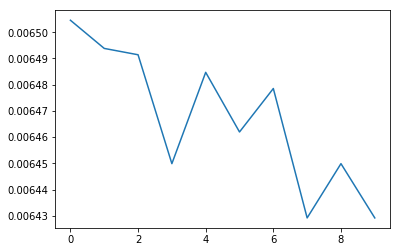

In [264]:
sse=calculate_WSS(np.array(toronto_grouped.drop('Neighborhood', 1)),10)
pd.Series(sse).plot(kind='line')

From above 7 seems to be a good number of clusters

#### Run K mean for number of clusters selected

In [268]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped.drop('Neighborhood', 1))

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 2, 1, 1, 5, 1, 2, 1])

In [269]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_grouped[["Neighborhood"]].copy()
#Add cluster labels
toronto_merged["Cluster Labels"]=kmeans.labels_
#merge the venues sorted dataframe to clustered dataframe
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted, on="Neighborhood")
#Assign geo data
toronto_merged=toronto_merged.merge(toronto_venues[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']],on='Neighborhood',how='left').drop_duplicates()

In [270]:
toronto_merged["Cluster Labels"].value_counts()

1    93
2    33
4    16
0    12
6     3
3     3
7     2
5     2
Name: Cluster Labels, dtype: int64

#### Cluster Visualization

In [271]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighborhood Latitude'], toronto_merged['Neighborhood Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Examination

In [280]:
#Check the most repeated category by ordered common category within each cluster 
cluster_summary=toronto_merged.groupby(['Cluster Labels']).agg(lambda x:x.value_counts().index[0]).drop(['Neighborhood','Neighborhood Longitude','Neighborhood Latitude'],1)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,
0,Gas Station,Convenience Store,Park,Yoga Studio,Restaurant,Falafel Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
1,Coffee Shop,Pizza Place,Coffee Shop,Convenience Store,Yoga Studio,Bank,Sandwich Place,Dessert Shop,Farmers Market,Fast Food Restaurant
2,Coffee Shop,Japanese Restaurant,Coffee Shop,Sandwich Place,Pub,Food Court,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
3,Playground,Furniture / Home Store,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market
4,Park,Park,Park,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
5,IT Services,Yoga Studio,Fish Market,Fish Market,Farm,Farm,Fast Food Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fish & Chips Shop
6,Park,Yoga Studio,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market
7,Train Station,Baseball Field,Fish Market,Falafel Restaurant,Fish Market,Farm,Fast Food Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fish & Chips Shop


By examining the most repeated venue for the most common venues in each cluster the type of neighborhood becomes apparent